In [797]:
import random
import re
import requests
import pandas as pd
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
from ipywidgets import widgets
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics


#Data I'm adding:
years = pd.Series(['2005','2006', '2007','2008', '2009', '2010','2011','2012', '2013','2014', '2015', '2016', 
         '2017', '2018','2019', '2020', '2021'])
years = [int(i) for i in years]
homeless_pop = pd.Series(['6026','6157', '5757','6044', '6228', '6539','6546','6954', '6865','7748', '7298', '8350', 
         '7473', '6904','6521', '6380', '5111'])
homeless_pop = [int(i) for i in homeless_pop]
dc_pop = pd.Series(['582049','585171', '588292','588363', '588433', '605125','619624','633427', '646669','658893', 
                    '672228', '681170', '693972', '702455','705749', '689545', '690345'])
dc_pop = [int(i) for i in dc_pop]
df_added_data = pd.DataFrame({'year': years, 'homeless_pop': homeless_pop, 'dc_pop' : dc_pop})
df_added_data.head()



,year,homeless_pop,dc_pop
0,2005,6026,582049
1,2006,6157,585171
2,2007,5757,588292
3,2008,6044,588363
4,2009,6228,588433


In [798]:
#Now to merge in data_added and do a little clean up

df_gender = pd.read_csv("InShelterPerDayGender.csv")
df_gender['date'] = pd.to_datetime(df_gender['date']) 
df_gender['day_of_year'] = df_gender['date'].apply(lambda x: int(x.strftime('%j')))
df_gender["MinTempF"] = pd.to_numeric(df_gender["MinTempF"])
df_gender['Total'] = df_gender['Male'] + df_gender['Female']
df_gender = df_gender.merge(df_added_data, how='left', left_on='year', right_on='year') #'how = left'
#print(df_gender.head())

df = pd.read_csv("InShelterPerDay.csv")
df['date'] = pd.to_datetime(df['date'])
df['day_of_year'] = df['date'].apply(lambda x: int(x.strftime('%j')))
df["MinTempF"] = pd.to_numeric(df["MinTempF"])
df = df.merge(df_added_data, how='left', left_on='year', right_on='year') #'how = left'
df["PrecipIn"] = df["PrecipIn"].fillna(0.0) #better to set unknowns to 0 than throw away data (small correlationto prediction)
df["SnowIn"] = df["SnowIn"].fillna(0.0) #better to set unknowns to 0 than throw away data (small correlationto prediction)

min_temp = df["MinTempF"].tolist()
first_entry = min_temp[0]
min_temp.pop()
prev_min_temp = [first_entry]
prev_min_temp.extend(min_temp)
df['prev_min_temp'] = pd.Series(prev_min_temp)
df["prev_min_temp"] = pd.to_numeric(df["prev_min_temp"])
    
df.head()

,date,Total,dayWeek,month,day,year,MinTempF,MaxTempF,SnowIn,PrecipIn,FreezingAtEntry,day_of_year,homeless_pop,dc_pop,prev_min_temp
0,2005-01-01,393,7,1,1,2005,39.92,59.00,0.0,0.000000,0.0,1,6026,582049,39.92
1,2005-01-02,451,1,1,2,2005,39.92,68.00,0.0,0.000000,0.0,2,6026,582049,39.92
2,2005-01-03,466,2,1,3,2005,39.92,46.94,0.0,0.000000,0.0,3,6026,582049,39.92
3,2005-01-04,469,3,1,4,2005,42.08,64.04,0.0,0.031496,0.0,4,6026,582049,39.92
4,2005-01-05,498,4,1,5,2005,46.94,69.08,0.0,0.181102,0.0,5,6026,582049,42.08


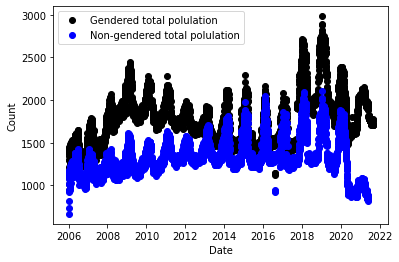

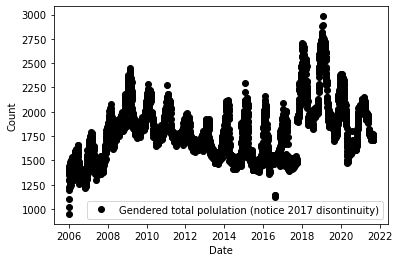

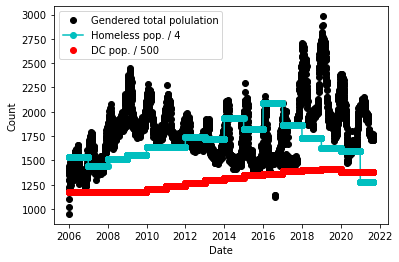

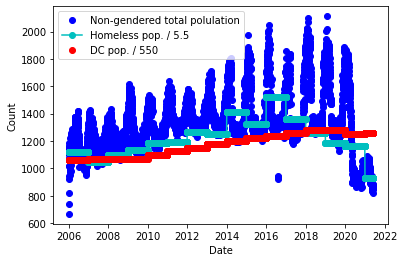

In [799]:
#Compare gendered and non-gendered data sets:

df_gender['ScaleDCPop'] = df_gender['dc_pop']/500
df_gender['ScaleHomelessPop'] = df_gender['homeless_pop']/4
mask_gender = (df_gender['date'] <= datetime(2021, 9, 1)) & (df_gender['date'] >= datetime(2006, 1, 1))
df_sub_gen = df_gender[['date', 'ScaleDCPop', 'ScaleHomelessPop', 'Total']].loc[mask_gender]
df_sub_gen = df_sub_gen.dropna()
X_gen = df_sub_gen['date']
y_tot_gen = df_sub_gen['Total']
y_hom_gen = df_sub_gen['ScaleHomelessPop']
y_dc_gen = df_sub_gen['ScaleDCPop']

df['ScaleDCPop'] = df['dc_pop']/550
df['ScaleHomelessPop'] = df['homeless_pop']/5.5
mask = (df['date'] <= datetime(2021, 6, 1)) & (df['date'] >= datetime(2006, 1, 1))
df_sub_nongen = df[['date', 'ScaleDCPop', 'ScaleHomelessPop', 'Total']].loc[mask]
df_sub_nongen = df_sub_nongen.dropna()
X_nongen = df_sub_nongen['date']
y_tot_nongen = df_sub_nongen['Total']
y_hom_nongen = df_sub_nongen['ScaleHomelessPop']
y_dc_nongen = df_sub_nongen['ScaleDCPop']

plt.plot(X_gen, y_tot_gen, 'o', color='k', label='Gendered total polulation');
plt.plot(X_nongen, y_tot_nongen, 'o', color='b', label='Non-gendered total polulation');
plt.xlabel('Date')
plt.ylabel('Count');
plt.legend();
plt.show()

plt.plot(X_gen, y_tot_gen, 'o', color='k', label='Gendered total polulation (notice 2017 disontinuity)');
plt.xlabel('Date')
plt.ylabel('Count');
plt.legend();
plt.show()

plt.plot(X_gen, y_tot_gen, 'o', color='k', label='Gendered total polulation');
plt.plot(X_gen, y_hom_gen, 'o-', color='c', label='Homeless pop. / 4');
plt.plot(X_gen, y_dc_gen, 'o', color='r', label='DC pop. / 500');
plt.xlabel('Date')
plt.ylabel('Count');
plt.legend();
plt.show()

plt.plot(X_nongen, y_tot_nongen, 'o', color='b', label='Non-gendered total polulation');
plt.plot(X_nongen, y_hom_nongen, 'o-', color='c', label='Homeless pop. / 5.5');
plt.plot(X_nongen, y_dc_nongen, 'o', color='r', label='DC pop. / 550');
plt.xlabel('Date')
plt.ylabel('Count');
plt.legend();
plt.show()



Training R^2 for training model range1: 0.7569134027871081
Training R^2 for testing model range1: 0.08958761194861686

Training R^2 for training model range2: 0.7934479948203774
Training R^2 for testing model range2: 0.8572134381948863



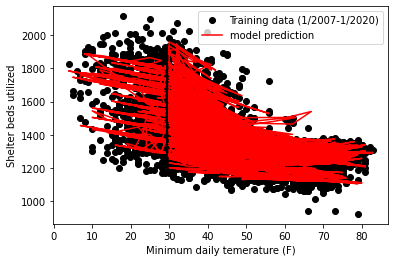

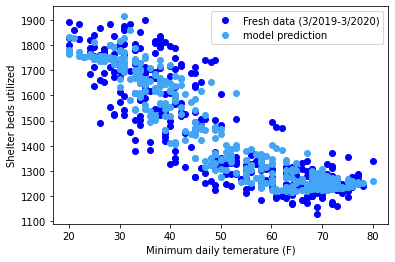

In [800]:
#Non-gendered data without one hot encoder added (no dayWeek data)

start_date = datetime(2007, 1, 1)
end_date = datetime(2020, 1, 1)
mask_train = (df['date'] > start_date) & (df['date'] <= end_date)
transition_temp = 29

df_train = df.loc[mask_train]
df_train = df_train[['MinTempF', 'dc_pop', 'homeless_pop', 'year', 'Total', 'day_of_year','PrecipIn', 'SnowIn']]
df_train = df_train.dropna()
mask_train_range1 = (df_train['MinTempF'] < transition_temp)
mask_train_range2 = (df_train['MinTempF'] >= transition_temp) & (df_train['MinTempF'] <= 300)
mask_train_range3 = (df_train['MinTempF'] > 60)#Not using this third region seperately anymore...
df_train1 = df_train.loc[mask_train_range1]
y_train1 = df_train1['Total']
X_train1 = df_train1[['MinTempF','dc_pop', 'homeless_pop', 'day_of_year', 'PrecipIn', 'SnowIn']] #could add more variables
df_train2 = df_train.loc[mask_train_range2]
y_train2 = df_train2['Total']
X_train2 = df_train2[['MinTempF','dc_pop', 'homeless_pop', 'day_of_year','PrecipIn', 'SnowIn']] #could add more variables
df_train3 = df_train.loc[mask_train_range3]
y_train3 = df_train3['Total']
X_train3 = df_train3[['MinTempF', 'dc_pop', 'homeless_pop', 'day_of_year', 'PrecipIn', 'SnowIn']] #could add more variables

start_date = datetime(2019, 3, 1)
end_date = datetime(2020, 3, 1)
mask_test = (df['date'] > start_date) & (df['date'] <= end_date)
df_test = df.loc[mask_test]
df_test = df_test[['MinTempF', 'dc_pop', 'homeless_pop','year', 'Total', 'day_of_year', 'PrecipIn', 'SnowIn']]
df_test = df_test.dropna()
mask_test_range1 = (df_test['MinTempF'] < transition_temp)
mask_test_range2 = (df_test['MinTempF'] >= transition_temp) & (df_test['MinTempF'] <= 300)
mask_test_range3 = (df_test['MinTempF'] > 60)#Not using this third region seperately anymore...
df_test1 = df_test.loc[mask_test_range1]
y_test1 = df_test1['Total']
X_test1 = df_test1[['MinTempF', 'dc_pop', 'homeless_pop', 'day_of_year', 'PrecipIn', 'SnowIn']] #could add more variables
df_test2 = df_test.loc[mask_test_range2]
y_test2 = df_test2['Total']
X_test2 = df_test2[['MinTempF', 'dc_pop', 'homeless_pop', 'day_of_year', 'PrecipIn', 'SnowIn']] #could add more variables

df_test3 = df_test.loc[mask_test_range3]
y_test3 = df_test3['Total']
X_test3 = df_test3[['MinTempF', 'dc_pop', 'homeless_pop', 'day_of_year', 'PrecipIn', 'SnowIn']] #could add more variables

linear_pipeline = Pipeline([('standard_scaler', StandardScaler()),
                    ('polynomial_trans', PolynomialFeatures(1)),
                    ('LinearReg', LinearRegression())])      
    
poly_pipeline = Pipeline([('standard_scaler', StandardScaler()),
                    ('polynomial_trans', PolynomialFeatures(3)),
                    #('standard_scaler2', StandardScaler()),
                    ('ridge', Ridge(alpha=10))])

linear_pipeline.fit(X_train1, y_train1)
y_pred_train1 = linear_pipeline.predict(X_train1)
y_pred_test1 = linear_pipeline.predict(X_test1)
model_train1 = metrics.r2_score(y_train1, y_pred_train1)
print('Training R^2 for training model range1:', model_train1)
model_test1 = metrics.r2_score(y_test1, y_pred_test1)
print('Training R^2 for testing model range1:', model_test1)
print('')

poly_pipeline.fit(X_train2, y_train2)
y_pred_train2 = poly_pipeline.predict(X_train2)
y_pred_test2 = poly_pipeline.predict(X_test2)
model_train2 = metrics.r2_score(y_train2, y_pred_train2)
print('Training R^2 for training model range2:', model_train2)
model_test2 = metrics.r2_score(y_test2, y_pred_test2)
print('Training R^2 for testing model range2:', model_test2)
print('')

linear_pipeline.fit(X_train3, y_train3)
y_pred_train3 = linear_pipeline.predict(X_train3)
y_pred_test3 = linear_pipeline.predict(X_test3)
model_train3 = metrics.r2_score(y_train3, y_pred_train3)
#print('Training R^2 for training model range3:', model_train3)
model_test3 = metrics.r2_score(y_test3, y_pred_test3)
#print('Training R^2 for testing model range3:', model_test3)

plt.plot(X_train1['MinTempF'], y_train1, 'o', color='k', label='Training data (1/2007-1/2020)');
plt.plot(X_train1['MinTempF'], y_pred_train1, color='r', label='model prediction');
plt.plot(X_train2['MinTempF'], y_train2, 'o', color='k');
plt.plot(X_train2['MinTempF'], y_pred_train2, color='r');
#plt.plot(X_train3['MinTempF'], y_train3, 'o', color='k');
#plt.plot(X_train3['MinTempF'], y_pred_train3, color='r');
plt.xlabel('Minimum daily temerature (F)')
plt.ylabel('Shelter beds utilized');
plt.legend();
plt.show()

plt.plot(X_test1['MinTempF'], y_test1, 'o', color='b', label='Fresh data (3/2019-3/2020)');
plt.plot(X_test1['MinTempF'], y_pred_test1, 'o', color='#42a5f5ff', label='model prediction');
plt.plot(X_test2['MinTempF'], y_test2, 'o', color='b');
plt.plot(X_test2['MinTempF'], y_pred_test2, 'o', color='#42a5f5ff');
#plt.plot(X_test3['MinTempF'], y_test3, 'o', color='b');
#plt.plot(X_test3['MinTempF'], y_pred_test3, color='#42a5f5ff');
plt.xlabel('Minimum daily temerature (F)')
plt.ylabel('Shelter beds utilized');
plt.legend();
plt.show()

In [801]:
#Quick test to see if dayWeek is correlated with shelter bed usage...it is (with max usage in mid-week; min on weekends)

start_date = datetime(2007, 1, 1)
end_date = datetime(2020, 1, 1)
mask_min = (df['date'] > start_date) & (df['date'] <= end_date)

df_min = df.loc[mask_min]
y = df_min['Total']

est = Pipeline([
    ('categorical', OneHotEncoder()),
    ('regressor', Ridge())
])

categorical_columns = ['dayWeek']
est.fit(df_min[categorical_columns], y)
est.predict(df_min[categorical_columns])
print(f'R^2 score using selected columns and transformers: {est.score(df_min[categorical_columns], y)}')

R^2 score using selected columns and transformers: 0.006073347536526219


Training R^2 for training model range1: 0.7736375304131015
Training R^2 for testing model range1: 0.036199747812158733

Training R^2 for training model range2: 0.8073368022518389
Training R^2 for testing model range2: 0.8483540069989035


C:\Users\klkry\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=5.47542e-37): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


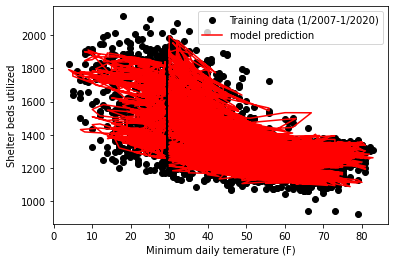

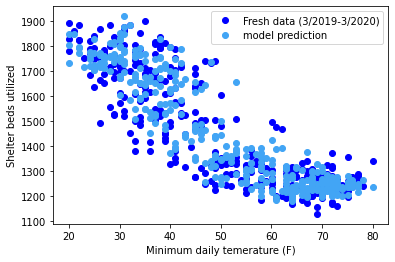

In [802]:
#Non-genered data including dayWeek categorical data:

test_start_date = datetime(2019, 3, 1)
test_end_date = datetime(2020, 3, 1)
transition_temp = 29

all_columns = ['prev_min_temp', 'dayWeek', 'year', 'MinTempF', 'dc_pop', 'homeless_pop', 'day_of_year','PrecipIn', 'SnowIn', 'Total']
X_columns = ['prev_min_temp','dayWeek', 'MinTempF', 'dc_pop', 'homeless_pop', 'day_of_year','PrecipIn', 'SnowIn']
X_columns_low = ['prev_min_temp','dayWeek','MinTempF', 'dc_pop', 'homeless_pop', 'day_of_year','PrecipIn', 'SnowIn']
numerical_columns = [ 'prev_min_temp', 'MinTempF', 'dc_pop', 'homeless_pop', 'day_of_year','PrecipIn', 'SnowIn'] #This will be sent to poly
categorical_columns = ['dayWeek']

train_start_date = datetime(2007, 1, 1)
train_end_date = datetime(2020, 1, 1)
mask_train = (df['date'] > train_start_date) & (df['date'] <= train_end_date)
df_trainB = df.loc[mask_train]
df_trainB = df_trainB[all_columns]
df_trainB = df_trainB.dropna()
y_train = df_trainB['Total']
X_train = df_trainB[X_columns]
mask_test = (df['date'] > test_start_date) & (df['date'] <= test_end_date)
df_testB = df.loc[mask_test]
df_testB = df_testB[all_columns]
df_testB = df_testB.dropna()
y_test = df_testB['Total']
X_test = df_testB[X_columns]

'''
#full range in one fit:
prep = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('numeric', 'passthrough', numerical_columns),
    ('standard_scaler', StandardScaler(), numerical_columns),
    ('polynomial_trans', PolynomialFeatures(3), numerical_columns)
])
est = Pipeline([
    ('features', prep),
    #('regressor', Ridge(alpha=10))
    ('LinearReg', LinearRegression())
])
est.fit(X_train,y_train)
#print(f'R^2 score using selected columns and transformers: {est.score(X_train, y_train)}')
y_pred_train = est.predict(X_train)
y_pred_test = est.predict(X_test)
model_train = metrics.r2_score(y_train, y_pred_train)
print('Training R^2 for training model range3:', model_train)
model_test = metrics.r2_score(y_test, y_pred_test)
print('Training R^2 for testing model range3:', model_test)

'''
#two fitted ranges:
mask_train_range1 = (df_trainB['MinTempF'] < transition_temp)
mask_train_range2 = (df_trainB['MinTempF'] >= transition_temp) & (df_trainB['MinTempF'] <= 150)
df_train1 = df_trainB.loc[mask_train_range1]
y_train1 = df_train1['Total']
X_train1 = df_train1[X_columns_low] #could add more variables
df_train2 = df_trainB.loc[mask_train_range2]
y_train2 = df_train2['Total']
X_train2 = df_train2[X_columns] #could add more variables

mask_test_range1 = (df_testB['MinTempF'] < transition_temp)
mask_test_range2 = (df_testB['MinTempF'] >= transition_temp) & (df_testB['MinTempF'] <= 150)
df_test1 = df_testB.loc[mask_test_range1]
y_test1 = df_test1['Total']
X_test1 = df_test1[X_columns_low] #could add more variables
df_test2 = df_testB.loc[mask_test_range2]
y_test2 = df_test2['Total']
X_test2 = df_test2[X_columns] #could add more variables


preplow = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('numeric', 'passthrough', numerical_columns),
    ('standard_scaler', StandardScaler(), X_columns_low),
    ('polynomial_trans', PolynomialFeatures(1), numerical_columns)
])
estlow = Pipeline([
    ('features', preplow),
    #('standard_scaler', StandardScaler()),
    #('polynomial_trans', PolynomialFeatures(1)),
    #('LinearReg', LinearRegression())
    ('regressor', Ridge(alpha=10))
])
estlow.fit(X_train1,y_train1)
y_pred_train1 = estlow.predict(X_train1)
y_pred_test1 = estlow.predict(X_test1)
model_train = metrics.r2_score(y_train1, y_pred_train1)
print('Training R^2 for training model range1:', model_train)
model_test = metrics.r2_score(y_test1, y_pred_test1)
print('Training R^2 for testing model range1:', model_test)
print('')
    
prepmid = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('numeric', 'passthrough', numerical_columns),
    ('standard_scaler', StandardScaler(), X_columns),
    ('polynomial_trans', PolynomialFeatures(3), numerical_columns)
])
estmid = Pipeline([
    ('features', prepmid),
    ('regressor', Ridge(alpha=10))
    #('LinearReg', LinearRegression())
])
estmid.fit(X_train2,y_train2)
y_pred_train2 = estmid.predict(X_train2)
y_pred_test2 = estmid.predict(X_test2)
model_train = metrics.r2_score(y_train2, y_pred_train2)
print('Training R^2 for training model range2:', model_train)
model_test = metrics.r2_score(y_test2, y_pred_test2)
print('Training R^2 for testing model range2:', model_test)

plt.plot(X_train1['MinTempF'], y_train1, 'o', color='k', label='Training data (1/2007-1/2020)');
plt.plot(X_train1['MinTempF'], y_pred_train1, color='r', label='model prediction');
plt.plot(X_train2['MinTempF'], y_train2, 'o', color='k');
plt.plot(X_train2['MinTempF'], y_pred_train2, color='r');
#plt.plot(X_train3['MinTempF'], y_train3, 'o', color='k');
#plt.plot(X_train3['MinTempF'], y_pred_train3, color='r');
plt.xlabel('Minimum daily temerature (F)')
plt.ylabel('Shelter beds utilized');
plt.legend();
plt.show()

plt.plot(X_test1['MinTempF'], y_test1, 'o', color='b', label='Fresh data (3/2019-3/2020)');
plt.plot(X_test1['MinTempF'], y_pred_test1, 'o',color='#42a5f5ff', label='model prediction');
plt.plot(X_test2['MinTempF'], y_test2, 'o', color='b');
plt.plot(X_test2['MinTempF'], y_pred_test2, 'o', color='#42a5f5ff');
#plt.plot(X_test3['MinTempF'], y_test3, 'o', color='b');
#plt.plot(X_test3['MinTempF'], y_pred_test3, color='#42a5f5ff');
plt.xlabel('Minimum daily temerature (F)')
plt.ylabel('Shelter beds utilized');
plt.legend();
plt.show()



In [803]:
df_anon = pd.read_csv("homelessness_anonymized_data.csv")
df_anon = df_anon.dropna()
df_anon["count"] = pd.to_numeric(df_anon["count"])
df_anon['date'] = pd.to_datetime(df_anon['date'])
print(df_anon.head())

        date  count  cat_index
0 2005-10-01      1          0
1 2005-10-02      1          0
2 2005-10-03      1          0
3 2005-10-04      1          0
4 2005-10-05      1          0


In [804]:
#df_anon.groupby(by=["cat_index"]).sum()

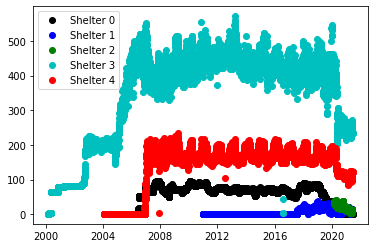

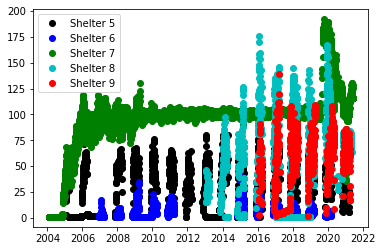

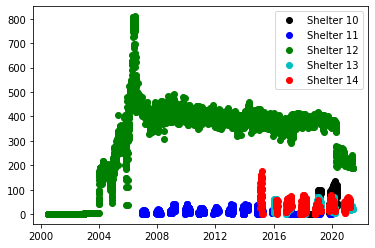

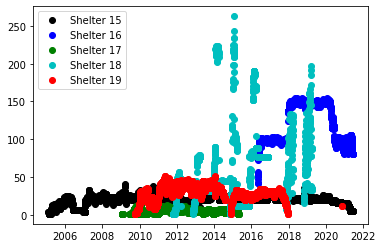

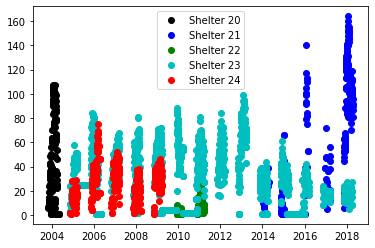

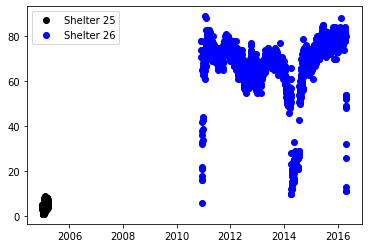

In [805]:
#Plotting shelter info -- different types (year-round, transient) and different periods of operation...

shelt_mask = (df_anon['cat_index'] == 0)
shelt0 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 1)
shelt1 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 2)
shelt2 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 3)
shelt3 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 4)
shelt4 = df_anon.loc[shelt_mask]

shelt_mask = (df_anon['cat_index'] == 5)
shelt5 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 6)
shelt6 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 7)
shelt7 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 8)
shelt8 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 9)
shelt9 = df_anon.loc[shelt_mask]

shelt_mask = (df_anon['cat_index'] == 10)
shelt10 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 11)
shelt11 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 12)
shelt12 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 13)
shelt13 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 14)
shelt14 = df_anon.loc[shelt_mask]

shelt_mask = (df_anon['cat_index'] == 15)
shelt15 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 16)
shelt16 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 17)
shelt17 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 18)
shelt18 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 19)
shelt19 = df_anon.loc[shelt_mask]

shelt_mask = (df_anon['cat_index'] == 20)
shelt20 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 21)
shelt21 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 22)
shelt22 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 23)
shelt23 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 24)
shelt24 = df_anon.loc[shelt_mask]

shelt_mask = (df_anon['cat_index'] == 25)
shelt25 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 26)
shelt26 = df_anon.loc[shelt_mask]

plt.plot(shelt0['date'], shelt0['count'], 'o', color='k', label='Shelter 0')
plt.plot(shelt1['date'], shelt1['count'], 'o', color='b', label='Shelter 1')
plt.plot(shelt2['date'], shelt2['count'], 'o', color='g', label='Shelter 2')
plt.plot(shelt3['date'], shelt3['count'], 'o', color='c', label='Shelter 3')
plt.plot(shelt4['date'], shelt4['count'], 'o', color='r', label='Shelter 4')
plt.legend();
plt.show()

plt.plot(shelt5['date'], shelt5['count'], 'o', color='k', label='Shelter 5')
plt.plot(shelt6['date'], shelt6['count'], 'o', color='b', label='Shelter 6')
plt.plot(shelt7['date'], shelt7['count'], 'o', color='g', label='Shelter 7')
plt.plot(shelt8['date'], shelt8['count'], 'o', color='c', label='Shelter 8')
plt.plot(shelt9['date'], shelt9['count'], 'o', color='r', label='Shelter 9')
plt.legend();
plt.show()

plt.plot(shelt10['date'], shelt10['count'], 'o', color='k', label='Shelter 10')
plt.plot(shelt11['date'], shelt11['count'], 'o', color='b', label='Shelter 11')
plt.plot(shelt12['date'], shelt12['count'], 'o', color='g', label='Shelter 12')
plt.plot(shelt13['date'], shelt13['count'], 'o', color='c', label='Shelter 13')
plt.plot(shelt14['date'], shelt14['count'], 'o', color='r', label='Shelter 14')
plt.legend();
plt.show()

plt.plot(shelt15['date'], shelt15['count'], 'o', color='k', label='Shelter 15')
plt.plot(shelt16['date'], shelt16['count'], 'o', color='b', label='Shelter 16')
plt.plot(shelt17['date'], shelt17['count'], 'o', color='g', label='Shelter 17')
plt.plot(shelt18['date'], shelt18['count'], 'o', color='c', label='Shelter 18')
plt.plot(shelt19['date'], shelt19['count'], 'o', color='r', label='Shelter 19')
plt.legend();
plt.show()

plt.plot(shelt20['date'], shelt20['count'], 'o', color='k', label='Shelter 20')
plt.plot(shelt21['date'], shelt21['count'], 'o', color='b', label='Shelter 21')
plt.plot(shelt22['date'], shelt22['count'], 'o', color='g', label='Shelter 22')
plt.plot(shelt23['date'], shelt23['count'], 'o', color='c', label='Shelter 23')
plt.plot(shelt24['date'], shelt24['count'], 'o', color='r', label='Shelter 24')
plt.legend();
plt.show()

plt.plot(shelt25['date'], shelt25['count'], 'o', color='k', label='Shelter 25')
plt.plot(shelt26['date'], shelt26['count'], 'o', color='b', label='Shelter 26')
plt.legend();
plt.show()